In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [3]:
STEPS = 50
STEP = 1/STEPS
CONST = (3 * np.cosh(np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) - 3 / (np.pi**2 + 1)) / np.sinh(np.sqrt((np.pi**2 + 1) / 3))
EPSILON = 1/100000 # точность порядка точного метода ДБСПФ

In [4]:
# двойное быстрое синус преобразование
def vector_dst(vector):
  matrix_x = np.stack([vector for _ in range(len(vector))])
  matrix_kn = np.arange(1,len(vector)+1).reshape(1,len(vector)) * np.arange(1,len(vector)+1).reshape(len(vector), 1)
  const = np.pi/(len(vector)+1)
  matrix_fi = matrix_kn*const
  matrix_sin = np.sin(matrix_fi)
  return np.sum(matrix_x * matrix_sin, axis = 1)
def dst(matrix):
  #return np.round(np.apply_along_axis(vector_dst, 0, matrix), 4)
  return np.apply_along_axis(vector_dst, 0, matrix)

# обратное
def vector_idst(vector):
  const = 2/(len(vector)+1)
  return const*vector_dst(vector)
def idst(matrix):
  #return np.round(np.apply_along_axis(vector_idst, 0, matrix), 4)
  return np.apply_along_axis(vector_idst, 0, matrix)

In [5]:
# правая функция уравнения 
def right_function(steps=STEPS, step = STEP, first_index = 0):
  right_f = np.zeros((steps-1, steps-1))
  for id_y in range(first_index, steps-1):
      for id_x in range(first_index, steps-1):
        right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x+1) * step)
  return right_f

In [6]:
# реализует аналитическое решение на заданной сетке
def get_analytical_Uxy(steps=STEPS, step = STEP):
  U_x_y = np.zeros((steps+1, steps+1))
  for id_x in range(0, steps):
    for id_y in range(0, steps):
      U_x_y[id_x, id_y] = np.sin(np.pi * (id_x) * step) * (-3 * np.cosh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)) / (np.pi**2 + 1) + 3 / (np.pi**2 + 1) + CONST * np.sinh((id_y) * step * np.sqrt((np.pi**2 + 1) / 3)))
  return U_x_y

# решение методом ДБСП
def get_double_fast_sine_conversion_Uxy(steps=STEPS, step = STEP):
  right_f = right_function(steps, step)
  start_time = time.clock()
  first_sine_conversion = idst(idst(right_f.T).T)/step**2
  own_lambda = np.zeros((steps-1, steps-1))
  for m in range(0, steps-1):
      for k in range(0, steps-1):
          own_lambda[k, m] = step**2 / (4 * (np.sin(np.pi * (k+1) * step * 0.5))**2 + 12 * (np.sin(np.pi * (m+1) * step * 0.5))**2 + step**2)
  second_sine_conversion  = dst(dst((own_lambda * first_sine_conversion).T).T)
  end_time = time.clock()
  sin_conv_with_zeros = np.zeros((steps + 1, steps + 1))
  for id_y in range(0, steps-1):
      for id_x in range(0, steps-1):
          sin_conv_with_zeros[id_x + 1, id_y + 1] = second_sine_conversion[id_x, id_y]
  return sin_conv_with_zeros, (end_time - start_time)

# решение методом Якоби
def Jacobi_method(U_x_y, steps=STEPS, step = STEP, epsilon = EPSILON):
  #U_x_y = get_analytical_Uxy(steps, step)
  time_start = time.clock()
  right_f = np.zeros((steps+1, steps+1))
  for id_y in range(1, steps):
      for id_x in range(1, steps):
          right_f[id_x, id_y] = 3 * step**2 * np.sin(np.pi * (id_x) * step)
  U_Jacobi = np.zeros((steps+1, steps+1))
  iterations = 0
  U_Jacobi_prev = U_Jacobi
  while np.amax(U_x_y - U_Jacobi) > epsilon :
    print(np.amax(U_x_y - U_Jacobi))
    for id_x in range(1, steps):
        for id_y in range(1, steps):
            U_Jacobi[id_x, id_y] = (right_f[id_x, id_y] + U_Jacobi_prev[id_x - 1, id_y] + U_Jacobi_prev[id_x + 1, id_y] + 3 * U_Jacobi_prev[id_x, id_y - 1] + 3 * U_Jacobi_prev[id_x, id_y + 1]) / (8 + step**2)
    iterations +=1
    U_Jacobi_prev = U_Jacobi
  time_end = time.clock()
  return U_Jacobi, (time_end - time_start), iterations

In [7]:
# рисунок решения в 3D
def get_draw(u_x_y, title, grid_step):
  X, Y = np.mgrid[0:1:grid_step, 0:1:grid_step]
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X, Y, u_x_y, cmap='inferno')
  ax.set_title(title)
  ax.legend()

No handles with labels found to put in legend.


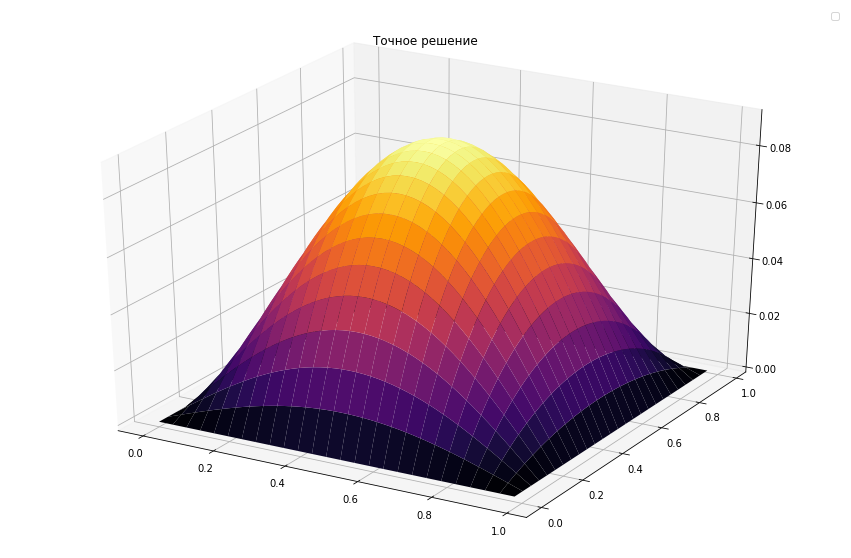

In [77]:
analytical_Uxy = get_analytical_Uxy()
get_draw(analytical_Uxy, "Точное решение", 1/(STEPS+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
No handles with labels found to put in legend.


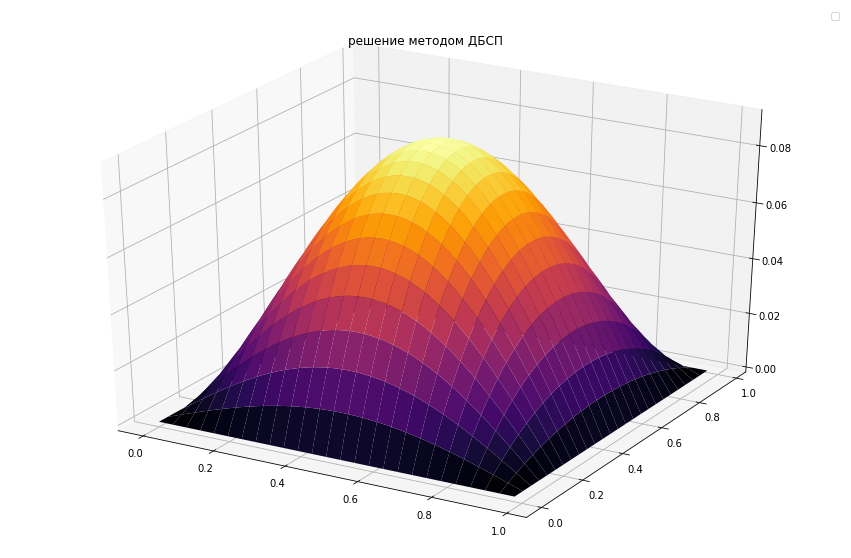

In [78]:
sin_conv, del_time = get_double_fast_sine_conversion_Uxy()
get_draw(sin_conv, "решение методом ДБСП", 1/(STEPS+1))

No handles with labels found to put in legend.


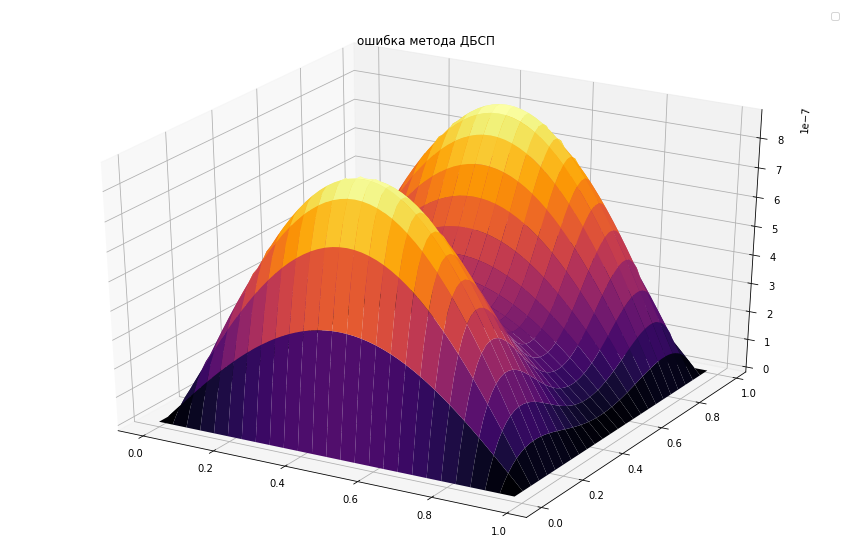

In [79]:
get_draw(analytical_Uxy - sin_conv, "ошибка метода ДБСП", 1/(STEPS+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.0905323416305544
0.0902325932956502
0.08993317032616603
0.08963407237413948
0.08933529910136848
0.08903685018882261
0.08873872535041831
0.08844092435111102
0.08814344702872273
0.08784629331851747
0.08754946327930503
0.08725295711978891
0.08695677522394663
0.08666091817439847
0.08636538677293959
0.08607018205764887
0.08577530531621806
0.08548075809535068
0.08518654220625359
0.08489265972638106
0.0845991129976931
0.08430590462175892
0.08401303745207894
0.08372051458401748
0.0834283393427399
0.08313651526953582
0.08284504610707076
0.08255393578447741
0.08226318840356649
0.08197280822756446
0.08168279967357508
0.0813931673094839
0.08110391585542834
0.08081505018939253
0.08052657535605406
0.08023849657775374
0.07995081926637415
0.07966354903496714
0.07937669170812099
0.07909025333026476
0.07880424017133306
0.07851865872943484
0.07823351573036862
0.07794881812399213
0.07766457307758706
0.07738078796645667
0.07709747036206036
0.07681462801802916
0.07653226885442382
0.076250400940597
0.07596

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
No handles with labels found to put in legend.


1.0539093901792973e-05
1.0496492366326993e-05
1.0454063036166583e-05
1.0411805215215786e-05
1.0369718210223589e-05
1.0327801330672903e-05
1.0286053888933222e-05
1.0244475200066328e-05
1.0203064581937316e-05
1.0161821355172962e-05
1.0120744843147844e-05
1.007983437192883e-05
1.0039089270399981e-05


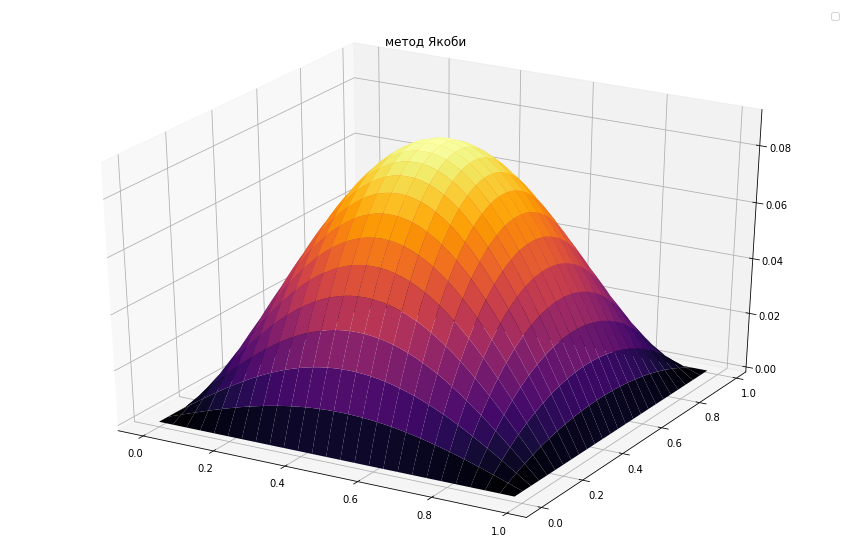

In [80]:
u_jacobi, jacobi_time, iterations = Jacobi_method(sin_conv)
get_draw(u_jacobi, "метод Якоби", 1/(STEPS+1))

No handles with labels found to put in legend.


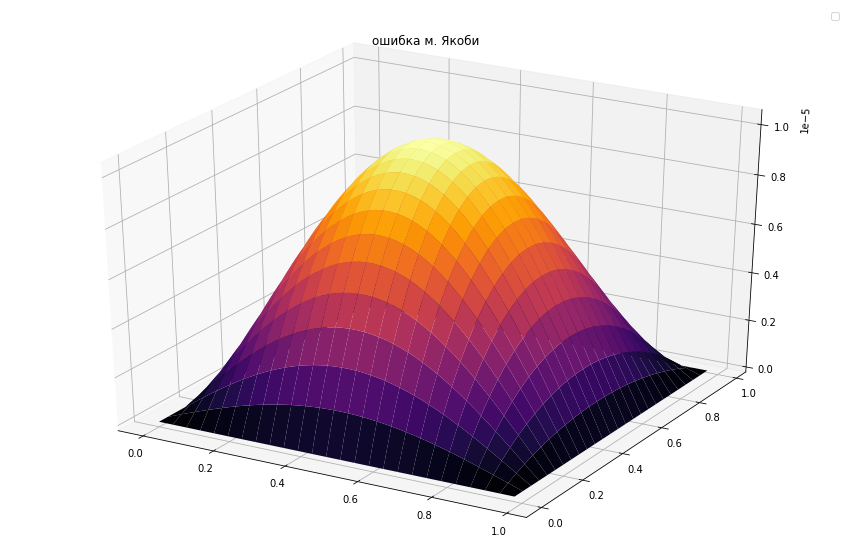

In [81]:
get_draw(analytical_Uxy - u_jacobi, "ошибка м. Якоби", 1/(STEPS+1))

In [ ]:
# сравнение времени работы 
array_sine_time = []
array_jacobi_time = []
array_jacobi_iterations = []
array_u_sine = []
array_U_jacobi = []
array_n = [10, 25, 50, 75, 100, 150, 200]

for steps in array_n:
  step = 1/steps
  U_sine, sine_time = get_double_fast_sine_conversion_Uxy(steps, step)
  array_u_sine.append(U_sine)
  array_sine_time.append(sine_time)
  U_jacobi, jacobi_time, iterations = Jacobi_method(U_sine, steps, step) # EPSILON = 1/10000 , сравниваем с Фурье
  array_U_jacobi.append(U_jacobi)
  array_jacobi_time.append(jacobi_time)
  array_jacobi_iterations.append(iterations)

In [18]:
import pandas as pd
pd.DataFrame({"Разбиение": array_n,
              "ДБСП (сек)": array_sine_time,
              "м.Якоби (сек)": array_jacobi_time,
              "итер м.Якоби": array_jacobi_iterations})

,Разбиение,ДБСП (сек),м.Якоби (сек),итер м.Якоби
0,10,0.005329,0.103401,90
1,25,0.012461,1.450491,565
2,50,0.054539,16.870530,2260
3,75,0.139424,80.047144,5087
4,100,0.285909,248.219356,9044
5,150,0.758575,1242.657048,20349
6,200,1.701735,3832.171226,36176


In [10]:
def norm_func(u):
  # максимум модуля 
  return np.amax(np.absolute(u))

In [19]:
# посчитаем по правилу Рунге оценку погрешности и фактическую скорость сходимости (2 или меньше). возьмем при n = 50 и n = 100

u_sin_50 = array_u_sine[4]
u_sin_100 = array_u_sine[-1]

U_jacobi_50 = array_U_jacobi[4]
U_jacobi_100 = array_U_jacobi[-1]

p = np.log2((np.absolute(norm_func(U_jacobi_50) - norm_func(U_jacobi_100))/np.absolute(norm_func(u_sin_100) - norm_func(U_jacobi_50)))+1)
delta_method_theory = (np.absolute(norm_func(U_jacobi_50) - norm_func(U_jacobi_100)))/3
delta_method_real = (np.absolute(norm_func(U_jacobi_50) - norm_func(U_jacobi_100)))/(2**p - 1)
print(f"теоретическая погрешность метода с p = {2} : ", delta_method_theory)
print(f"реальная погрешность метода с p = {p} : ", delta_method_real)

теоретическая погрешность метода с p = 2 :  2.0579549467325542e-08
реальная погрешность метода с p = 0.00882631096268329 :  1.0060585653392937e-05


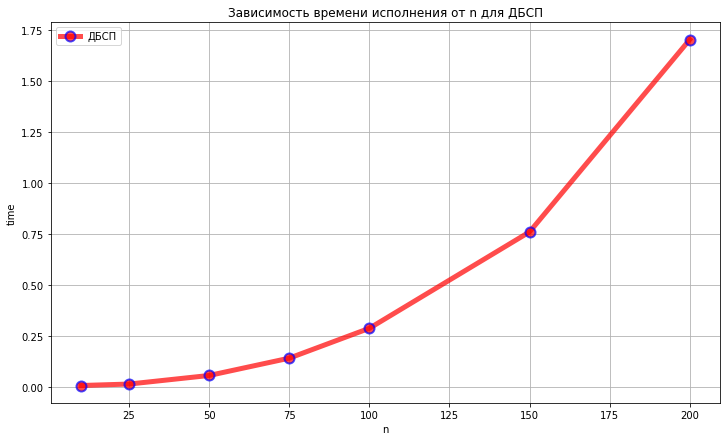

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_sine_time, 'o-r', alpha=0.7, label="ДБСП", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для ДБСП")
plt.legend()
plt.grid(True)

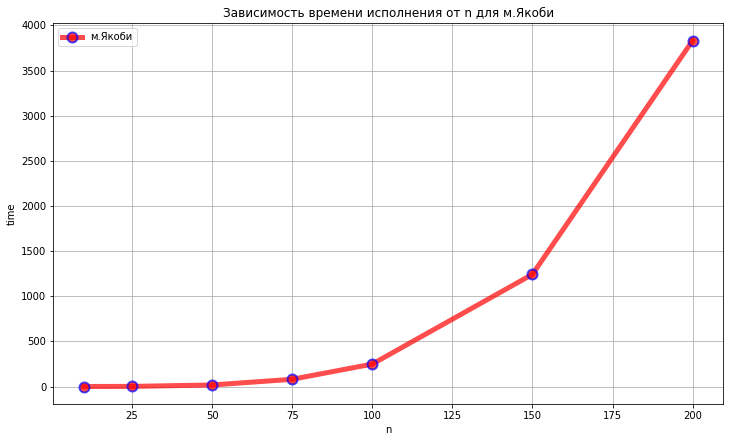

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(array_n, array_jacobi_time, 'o-r', alpha=0.7, label="м.Якоби", lw=5, mec='b', mew=2, ms=10)
plt.xlabel("n")
plt.ylabel("time")
plt.title("Зависимость времени исполнения от n для м.Якоби")
plt.legend()
plt.grid(True)